In [200]:
import random
from datetime import datetime, timedelta

import pandas as pd
import matplotlib.pyplot as plt

### Wczytanie i przygotowanie danych

In [201]:
plan = pd.read_csv('data/schedules/schedule_1.csv', sep=None, engine='python')
pref = pd.read_csv('data/preferences/preferences_1.csv')

In [202]:
plan['start_time'] = pd.to_datetime(plan['start_time'], format='%H:%M').dt.time

# Zmiana typu zajęć na ich pojemność
capacities = {
    'L': 15,
    'P': 15,
    'C': 30,
}

plan = plan[plan['type'] != 'W']
plan['type'] = plan['type'].map(capacities)
plan.rename(columns={'type': 'capacity'}, inplace=True)
plan.head(5)

,subject,specialization,capacity,Unnamed: 3,group_id,teacher,classroom,week,day,start_time
0,Przedmiot-1,G,30,30,1,Prowadzący-15,3.27a,NaN,Cz,16:45:00
1,Przedmiot-1,G,30,30,2,Prowadzący-15,3.27b,NaN,Cz,16:45:00
2,Przedmiot-1,G,30,30,3,Prowadzący-15,3.27a,NaN,Cz,18:30:00
3,Przedmiot-1,G,30,30,4,Prowadzący-15,3.27c,NaN,Cz,16:45:00
4,Przedmiot-1,G,30,30,5,Prowadzący-15,3.27b,NaN,Cz,16:45:00


### Przydatne struktury i funkcje pomocniczne


In [203]:
from collections import defaultdict

# Przydatne struktury
students = pref['student_id'].unique()
subjects = plan['subject'].unique()

# Liczba grup dla każdego przedmiotu:
# subject -> number of groups
num_groups = {}
for subject in subjects:
    n = plan[plan['subject'] == subject]['group_id'].nunique()
    num_groups[subject] = n

# Preferencje studentów dla danych grup:
# (student_id, subject, group_id): preference
pref_dict = {
    (row.student_id, row.subject, row.group_id): row.preference
    for row in pref.itertuples()
}

# Pojemności grup:
# (subject, group_id): capacity
cap_dict = {
    (row.subject, row.group_id): row.capacity
    for row in plan.itertuples()
}

# Posortowane preferencje (malejąco po przyznanych punktach):
# (student_id, subject): list of (group_id, preference)
pref_sorted = pref.sort_values(by=['student_id', 'subject', 'preference'], ascending=[True, True, False])
pref_dict_sorted = defaultdict(list) 
for row in pref_sorted.itertuples():
    pref_dict_sorted[(row.student_id, row.subject)].append((row.group_id, row.preference))

# Przedziały czasowe zajęć poszczególnych grup
# (subject, group_id) -> (day, start_time, end_time)
schedule_dict = {}
DUR = timedelta(minutes=90)
for row in plan.itertuples():
    start = datetime.combine(datetime.today(), row.start_time)
    schedule_dict[(row.subject, row.group_id)] = (
        row.day,
        row.start_time,
        (start + DUR).time()
    )


In [204]:
def conflicts(day_a, start_a, end_a, day_b, start_b, end_b):
    if day_a != day_b:
        return False
    return (start_a < end_b) and (start_b < end_a)

### Tworzenie populacji

In [205]:
def generate_individual(students, subjects, cap_dict, pref_dict_sorted):
    """
    Generuje jednego osobnika (kompletne przypisanie studentów do grup)

    Dla każdego studenta, przypisuje go do najbardziej preferowanej grupy, w której
    jest jeszcze miejsce, i która nie koliduje z jego obecnym planem. 
    Jeśli nigdzie nie ma miejsca, przypisuje go do grupy z najmniejszym przepełnieniem.
    """

    occupancy = {key: 0 for key in cap_dict}
    reserved = {stu: [] for stu in students}

    df = pd.DataFrame(index=students, columns=subjects)

    for student in students:
        for subject in subjects:

            prefs = pref_dict_sorted[(student, subject)]
            for group_id, _pts in prefs:

                # Sprawdza czy w grupie jest miejsce
                cap = cap_dict.get((subject, group_id), 0)
                if occupancy[(subject, group_id)] >= cap:
                    continue

                # Sprawdza czy student nie ma w tym czasie innych zajęć
                day, s, e = schedule_dict[(subject, group_id)]
                if any(conflicts(day, s, e, d0, s0, e0) for d0, s0, e0 in reserved[student]):
                    continue

                df.loc[student, subject] = group_id
                occupancy[(subject, group_id)] += 1
                reserved[student].append((day, s, e))
                break
            else:
                # !!! To może generować kolizje w planie.
                # awaryjnie: w każdej grupie full – weź losową z najmniejszym przepełnieniem
                fallback = min(
                    [(g, occ) for (subj, g), occ in occupancy.items() if subj == subject],
                    key=lambda t: t[1]
                )[0]
                df.loc[student, subject] = fallback
                occupancy[(subject, fallback)] += 1

    return df          

In [206]:
def generate_population(size, students, subjects, num_groups):
    population = []

    for _ in range(size):
        shuffled = students.copy()
        random.shuffle(shuffled)
        ind = generate_individual(students, subjects, cap_dict, pref_dict_sorted)
        population.append(ind)
    return population

### Algorytm genetyczny

In [207]:
# TODO Zrobić żeby miało sens
def mutate(individual, num_groups, mutation_rate=0.1):
    """
    Dokonuje mutacji osobnika.

    Obecnie, losowo zmienia grupy studentom.
    """
    mutated = individual.copy()

    for student in mutated.index:
        for subject in mutated.columns:
            if random.random() < mutation_rate:
                new_group = random.randint(1, num_groups[subject])
                mutated.loc[student, subject] = new_group

    return mutated

In [208]:
# TODO Zrobić, żeby miało sens
def crossover(parent1, parent2):
    """
    Krzyżuje dwóch osobników i zwraca nowego.

    Obecnie, bierze pół planu od jednego rodzica i pół do drugiego
    nie patrząc na żadne warunki Xd.
    """

    students = parent1.index.tolist()
    subjects = parent1.columns.tolist()
    cut = len(students) // 2

    child = pd.DataFrame(index=students, columns=subjects)

    for i, student in enumerate(students):
        source = parent1 if i < cut else parent2
        for subject in subjects:
            child.loc[student, subject] = source.loc[student, subject]

    return child

In [209]:
# Nie jest używane, na razie
def overflow_penalty(individual_df, cap_dict, penalty_per_person=100):
    
    melted = individual_df.melt(ignore_index=False, var_name='subject', value_name='group')
    counts = melted.groupby(['subject', 'group']).size()

    penalty = 0
    for (subject, group), count in counts.items():
        cap = cap_dict.get((subject, group), 0)
        if count > cap:
            penalty += (count - cap) * penalty_per_person

    return penalty

In [210]:
def fitness(individual, pref_dict):
    total_points = 0
    max_points = pref.groupby(['student_id', 'subject'])['preference'].max().sum()

    for student in individual.index:
        for subject in individual.columns:
            group = individual.loc[student, subject]
            key = (student, subject, group)
            points = pref_dict.get(key, 0) 

            total_points += points
    
    return round(total_points / max_points, 2)

In [211]:
def evolve(
    students, subjects, num_groups, pref_dict,
    population_size=100, generations=100,
    mutation_rate=0.1, elite_size=2
):
    population = generate_population(population_size, students, subjects, num_groups)
    best_individual = None
    best_fitness = -1e9
    history = []

    for gen in range(generations):
        scores = list(map(float, [fitness(individual, pref_dict) for individual in population]))
        max_f = max(scores)
        history.append(max_f)

        if max_f > best_fitness:
            best_fitness = max_f
            best_individual = population[scores.index(max_f)]

        sorted_indices = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)
        new_population = [population[i] for i in sorted_indices[:elite_size]]

        while len(new_population) < population_size:
            p1 = random.choice(population)
            p2 = random.choice(population)
            child = crossover(p1, p2)
            child = mutate(child, num_groups, mutation_rate)
            new_population.append(child)

        population = new_population

        if gen % 10 == 0 or gen == generations - 1:
            print(f"Pokolenie {gen}: najlepszy fitness = {max_f}")

    return best_individual, best_fitness, history

### Ewolucja i generowanie wyników

In [212]:
population = generate_population(20, students, subjects, num_groups)
scores = list(map(float, [fitness(individual, pref_dict) for individual in population]))
print(list(scores))

[0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68, 0.68]


In [213]:
best, score, history = evolve(
    students=students,
    subjects=subjects,
    num_groups=num_groups,
    pref_dict=pref_dict,
    population_size=20,
    generations=10,
    mutation_rate=0.1,
    elite_size=2
)

print("Najlepszy fitness:", score)

Pokolenie 0: najlepszy fitness = 0.68
Pokolenie 9: najlepszy fitness = 0.7
Najlepszy fitness: 0.7


In [214]:
best.to_csv('data/out/output1.csv', sep=';')

### Testy i statystyki

In [215]:
def score_per_student(df, pref_dict):

    scores = []
    max_points = pref.groupby(['student_id', 'subject'])['preference'].max()

    for student in df.index:
        student_max = max_points[student].sum()
        student_score = 0
        for subject in df.columns:
            group = df.loc[student, subject]
            key = (student, subject, group)
            points = pref_dict.get(key, 0) 

            student_score += points
        
        scores.append(round(student_score / student_max, 2))
    return scores
    

In [216]:
scores = score_per_student(best, pref_dict)

[np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(1.0), np.float64(0.98), np.float64(0.98), np.float64(0.98), np.float64(0.98), np.float64(0.98), np.float64(0.98), np.float64(0.98), np.float64(0.98), np.float64(0.98), np.float64(0.98), np.float64(0.98), np.float64(0.96), np.float64(0.96), np.float64(0.96), np.float64(0.96), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.95), np.float64(0.93), np.float64(0.93), np.float64(0.93), np.float64(0.93), np.float64(0.93), np.float64(0.92), np.float64(0.91), np.float64(0.91), np.float64(0.91), np.float64(0.91), np.float64(0.91), np.float64(0.89), np.float64(0.89), np.float64(0.89), np.float64(0.88), np.float64(0.87), np.float64(0.87), np.float64(0.87), np.float64(0.87), np.float64(0.87), np.float64(0.87), np.float64(0.85), np.float64(0.83), np.float64(0.83), np.float64(0.83), np.float64(0.83), np.float64(0.83), np.float64(0.83), np.float64(0.82),

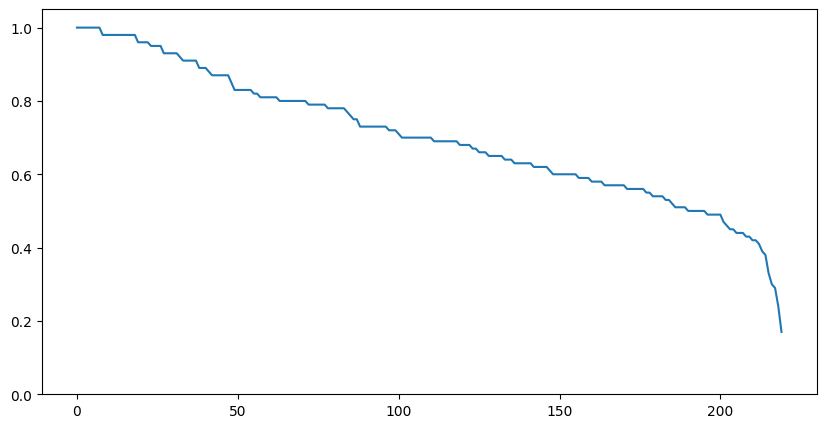

In [217]:
plt.figure(figsize=(10, 5))
plt.ylim(0,1.05)
plt.plot(sorted(scores, reverse=True))
print(sorted(scores, reverse=True))